# Supervised Learning - Assignment nº 2
## Loan Approval Prediction


### Description
The goal is to develop a machine learning model that predicts if a loan application is approved or not. 

The target variable is loan_status, a binary label where 1 indicates the loan is approved and 0 means it is not.

The dataset provided for training and testing was generated from a deep learning model trained on the Loan Approval Prediction dataset.

#### Files

- **train.csv**: Contains the training data, including the target variable loan_status.

- **test.csv**: Test data where the task is to predict the probability of loan approval (loan_status).

### Import libraries
Before running the notebook, make sure all the necessary libraries are installed.

This project includes a `requirements.txt` file that lists all dependencies.

To install them, run the following command in your terminal: ` pip install -r requirements.txt `

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Initial

In [5]:

data = pd.read_csv('train.csv')

print("First 5 rows of the dataset:")
print(data.head())
print("\n")


print("Summary statistics:")
print(data.describe())
print("\n")


print("Dataset info:")
print(data.info())
print("\n")

print("Status:")
print(data['loan_status'].unique())


First 5 rows of the dataset:
   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  

### Exploratory Data Analysis 


--- Distribution of target variable ---
loan_status
0    85.761787
1    14.238213
Name: proportion, dtype: float64


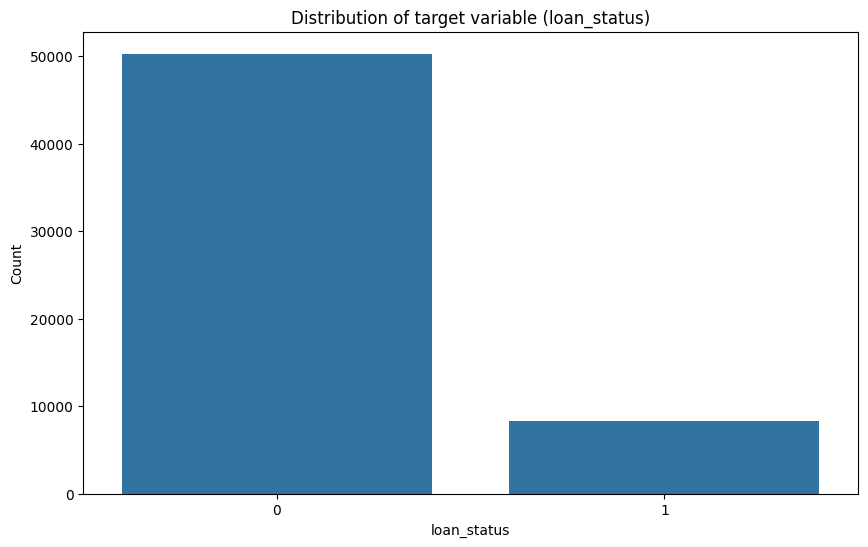

In [ ]:
print("\n--- Distribution of target variable ---")
loan_status_counts = data['loan_status'].value_counts(normalize=True) * 100
print(loan_status_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='loan_status', data=data)
plt.title('Distribution of target variable (loan_status)')
plt.ylabel('Count')
plt.show()

In [ ]:
print("\n--- Missing values ---")
missing_values = data.isnull().sum()
print(missing_values)

print("Rows containing missing values:")
print(data[data.isnull().any(axis=1)])


--- Missing values ---
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64
Rows containing missing values:
Empty DataFrame
Columns: [id, person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length, loan_status]
Index: []



=== Analysis of person_age ===
count   58645.000
mean       27.551
std         6.033
min        20.000
25%        23.000
50%        26.000
75%        30.000
max       123.000
Name: person_age, dtype: float64

Missing values: 0 (0.00%)
Outliers: 2446 (4.17%)
Median: 26.0
Mode: 23


Variance: 36.39969254217415


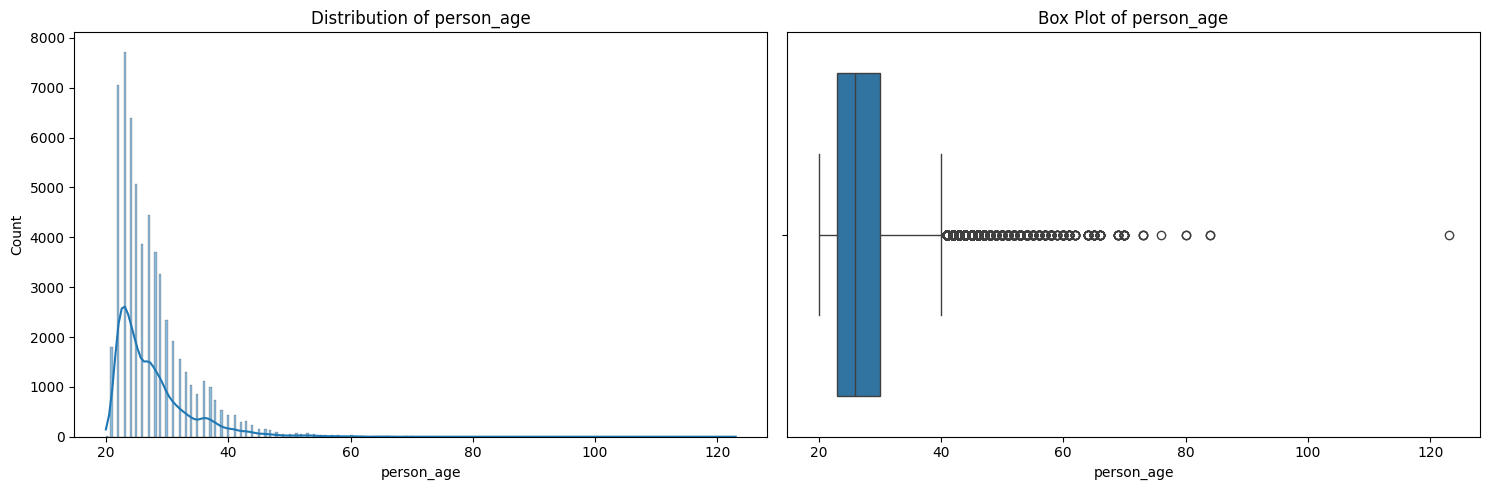

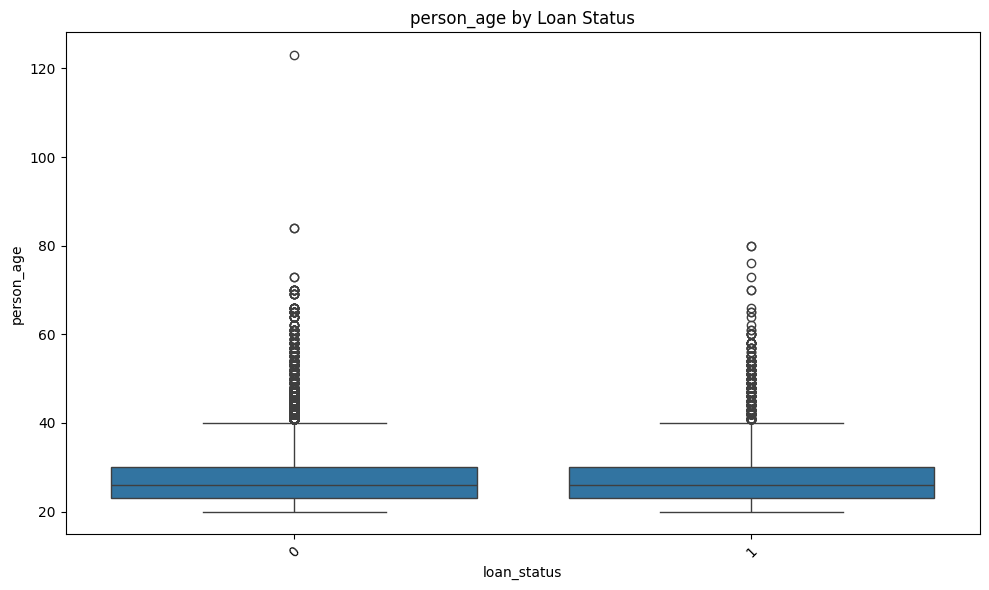


=== Analysis of person_income ===
count     58645.000
mean      64046.173
std       37931.107
min        4200.000
25%       42000.000
50%       58000.000
75%       75600.000
max     1900000.000
Name: person_income, dtype: float64

Missing values: 0 (0.00%)
Outliers: 2411 (4.11%)
Median: 58000.0
Mode: 60000
Variance: 1438768876.6143749


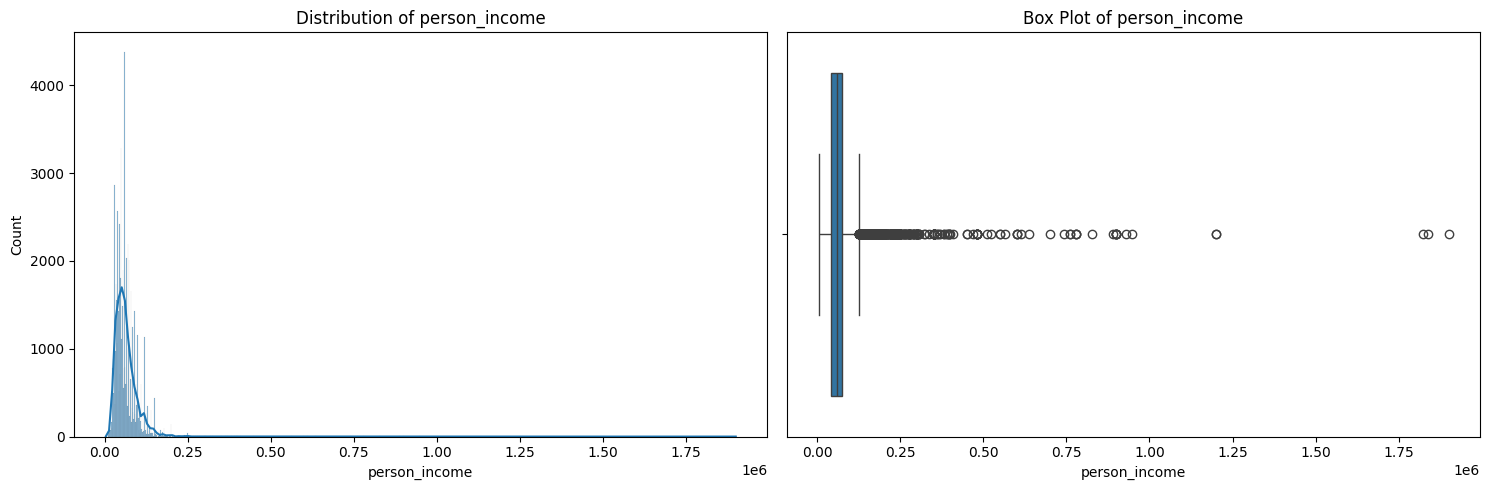

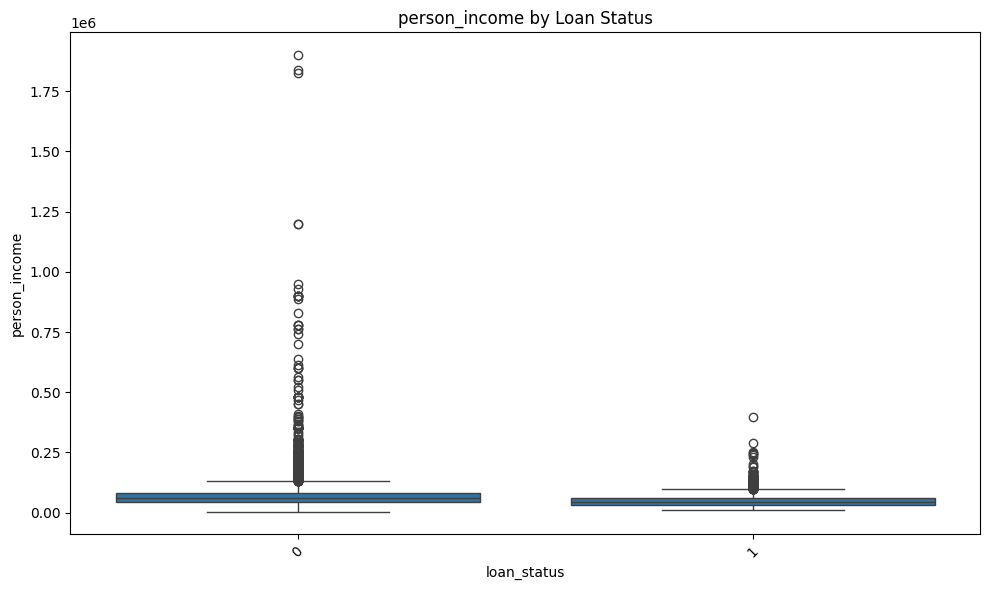


=== Analysis of person_emp_length ===
count   58645.000
mean        4.701
std         3.960
min         0.000
25%         2.000
50%         4.000
75%         7.000
max       123.000
Name: person_emp_length, dtype: float64

Missing values: 0 (0.00%)
Outliers: 1274 (2.17%)
Median: 4.0
Mode: 0.0
Variance: 15.679892054302824


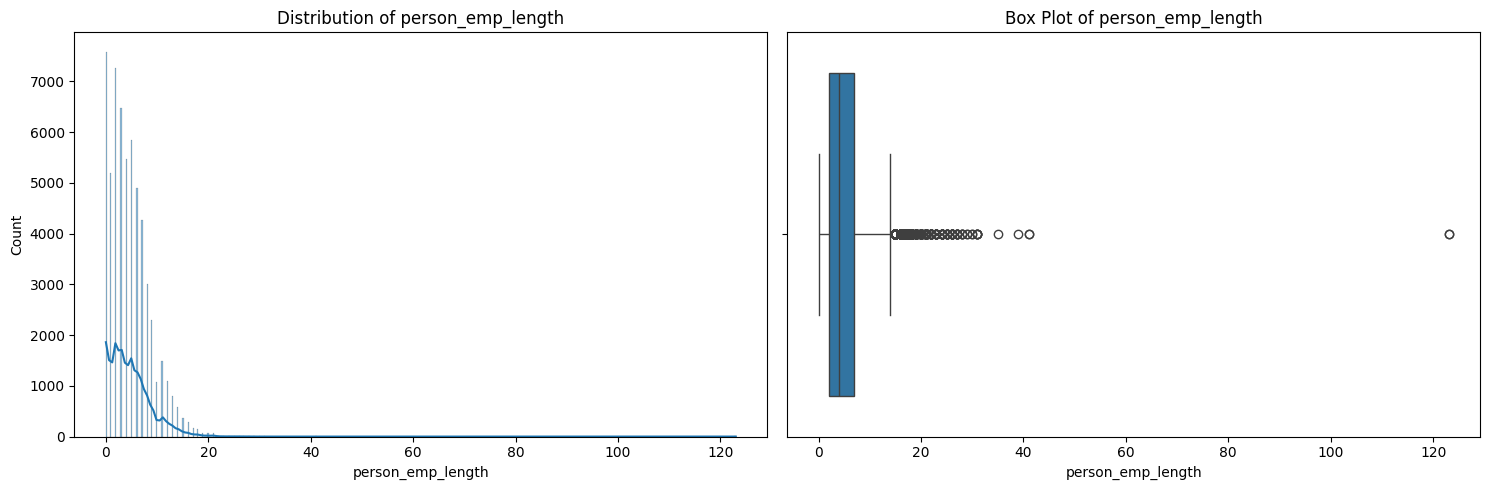

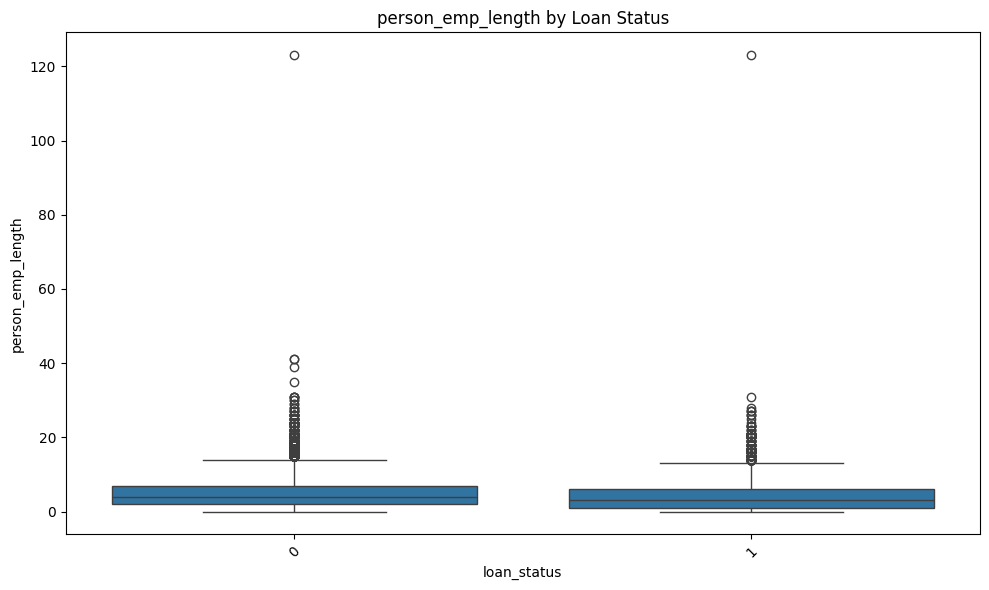


=== Analysis of loan_amnt ===
count   58645.000
mean     9217.557
std      5563.807
min       500.000
25%      5000.000
50%      8000.000
75%     12000.000
max     35000.000
Name: loan_amnt, dtype: float64

Missing values: 0 (0.00%)
Outliers: 2045 (3.49%)
Median: 8000.0
Mode: 10000
Variance: 30955952.608074497


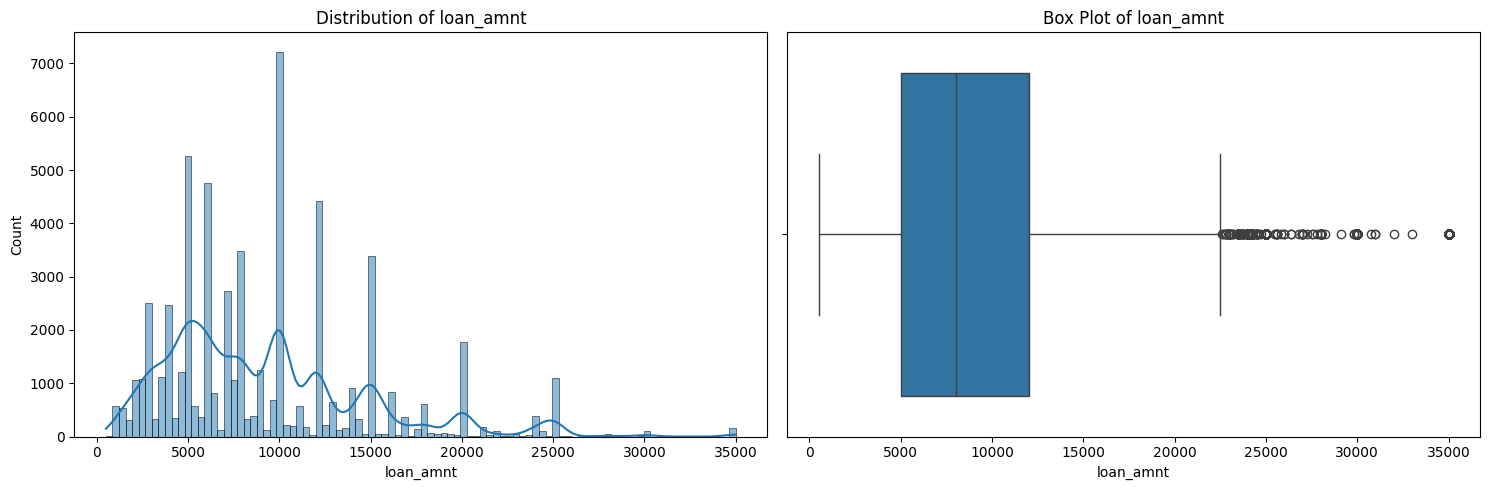

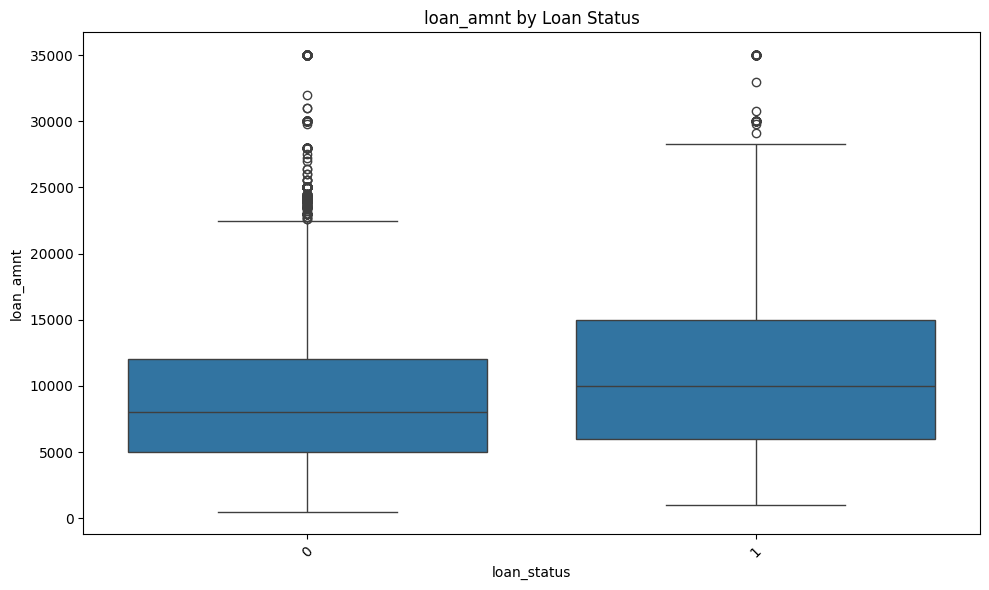


=== Analysis of loan_int_rate ===
count   58645.000
mean       10.678
std         3.035
min         5.420
25%         7.880
50%        10.750
75%        12.990
max        23.220
Name: loan_int_rate, dtype: float64

Missing values: 0 (0.00%)
Outliers: 34 (0.06%)
Median: 10.75
Mode: 10.99
Variance: 9.209387114731488


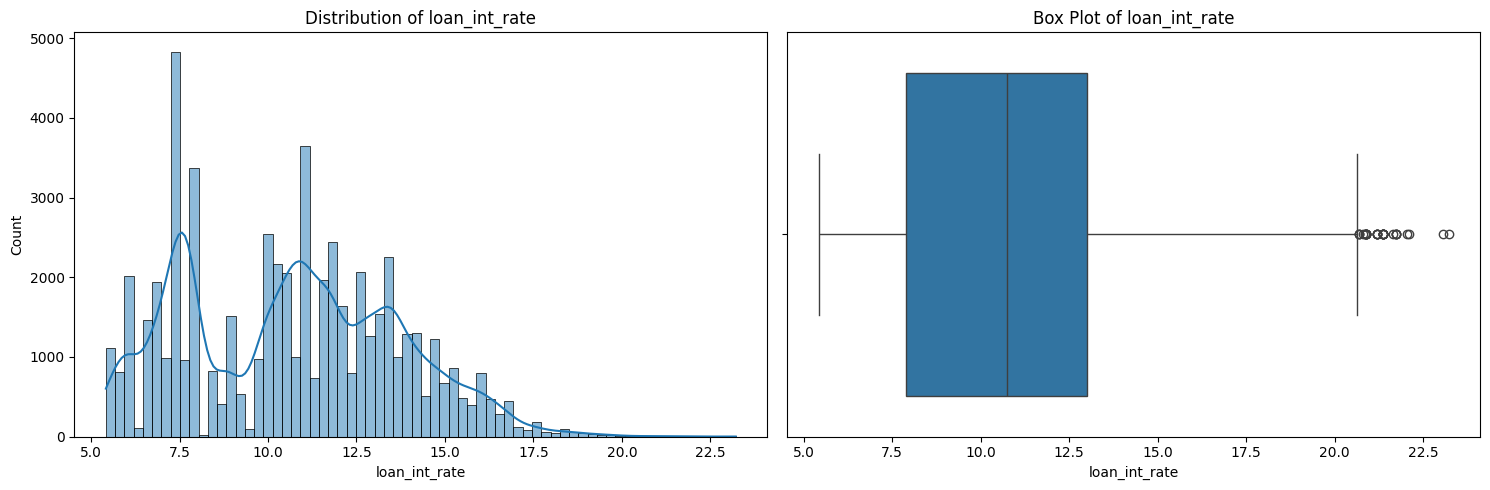

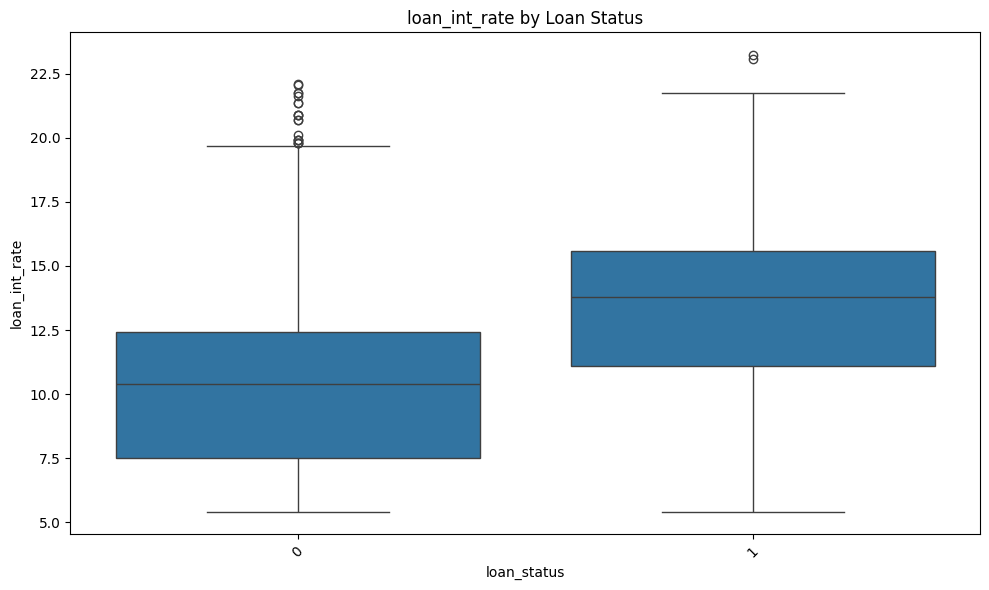


=== Analysis of loan_percent_income ===
count   58645.000
mean        0.159
std         0.092
min         0.000
25%         0.090
50%         0.140
75%         0.210
max         0.830
Name: loan_percent_income, dtype: float64

Missing values: 0 (0.00%)
Outliers: 1210 (2.06%)
Median: 0.14
Mode: 0.1
Variance: 0.008407384910127548


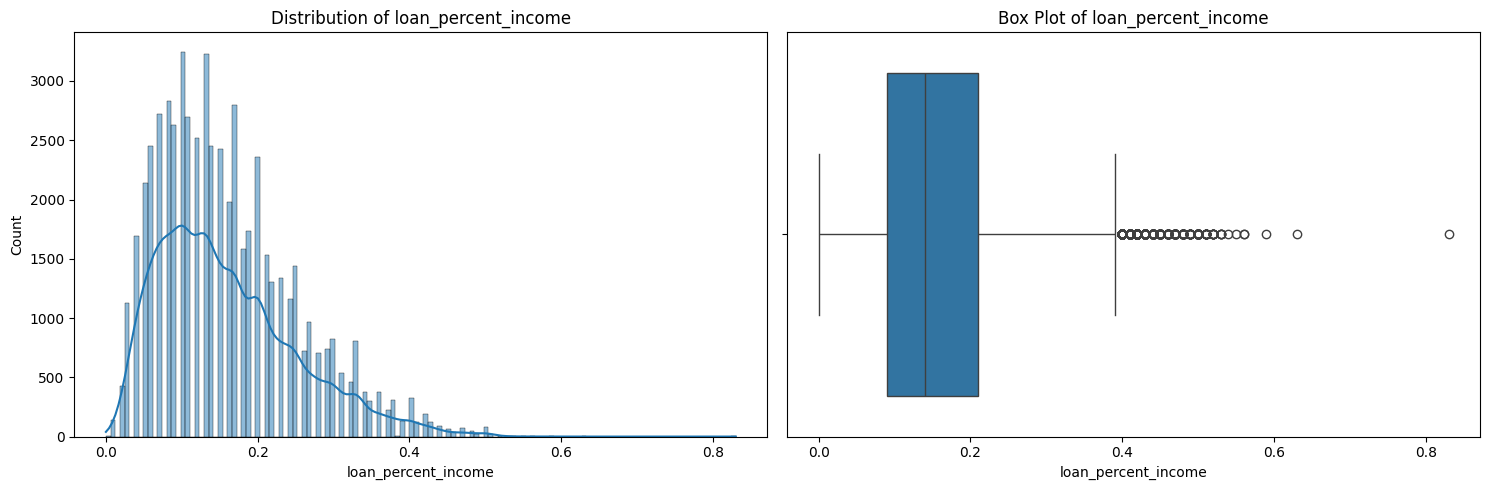

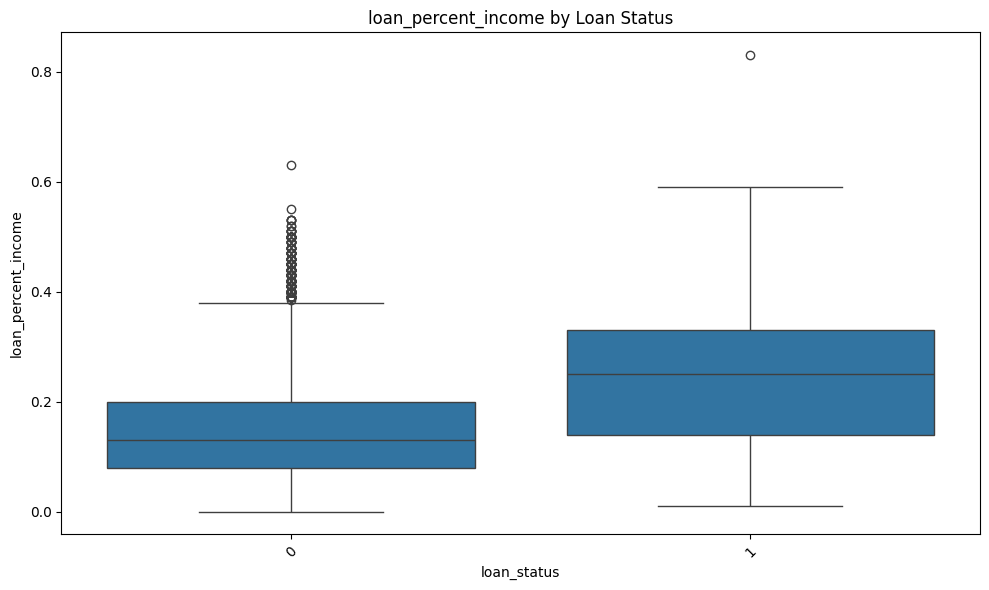


=== Analysis of cb_person_cred_hist_length ===
count   58645.000
mean        5.814
std         4.029
min         2.000
25%         3.000
50%         4.000
75%         8.000
max        30.000
Name: cb_person_cred_hist_length, dtype: float64

Missing values: 0 (0.00%)
Outliers: 1993 (3.40%)
Median: 4.0
Mode: 3
Variance: 16.234421643585016


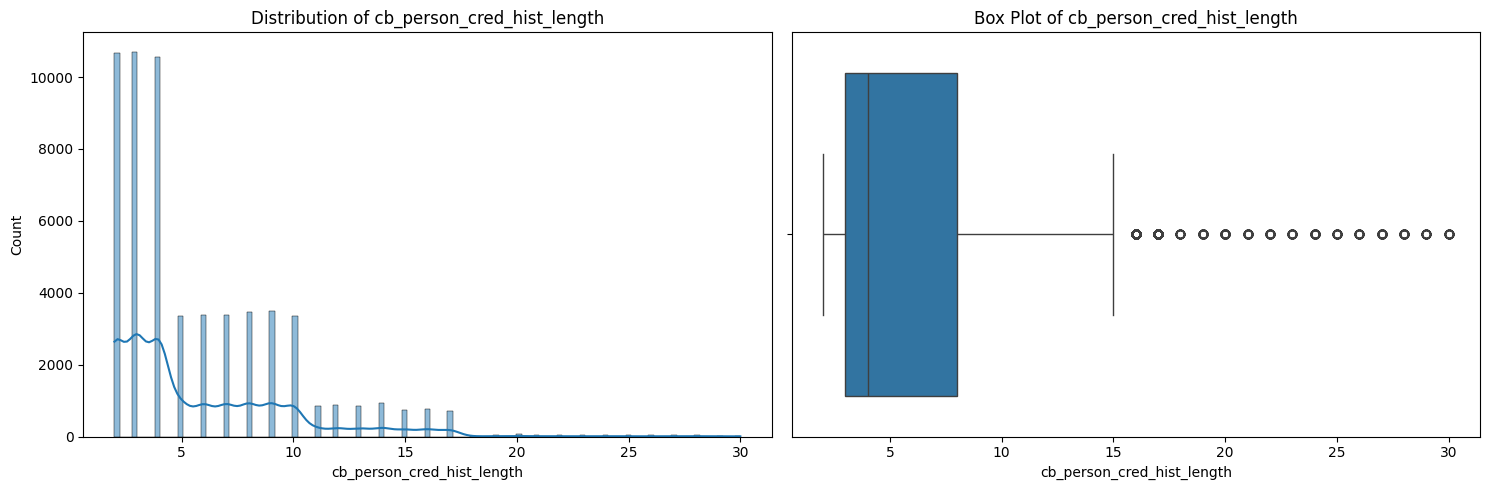

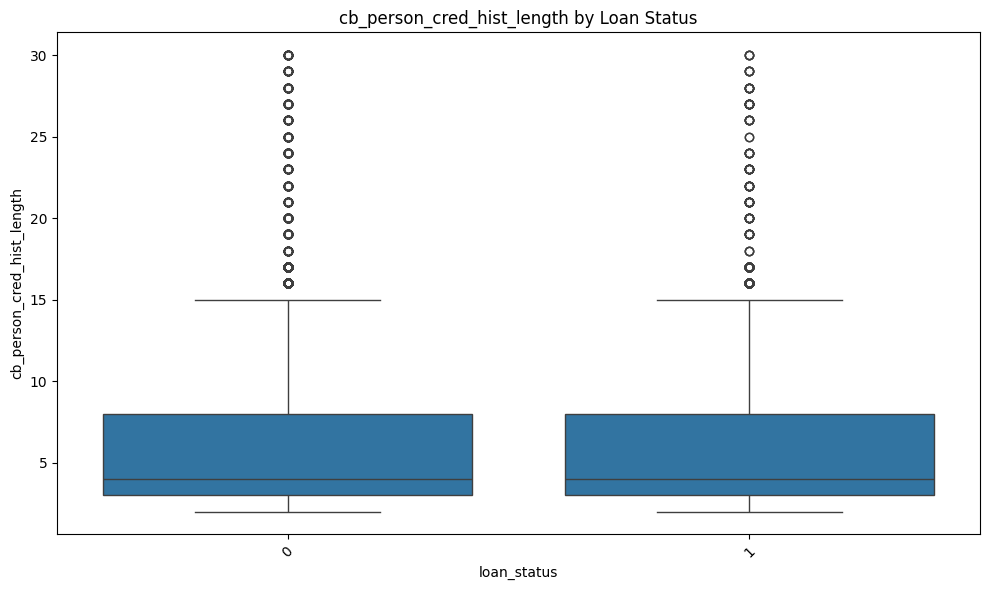


=== Analysis of person_home_ownership ===


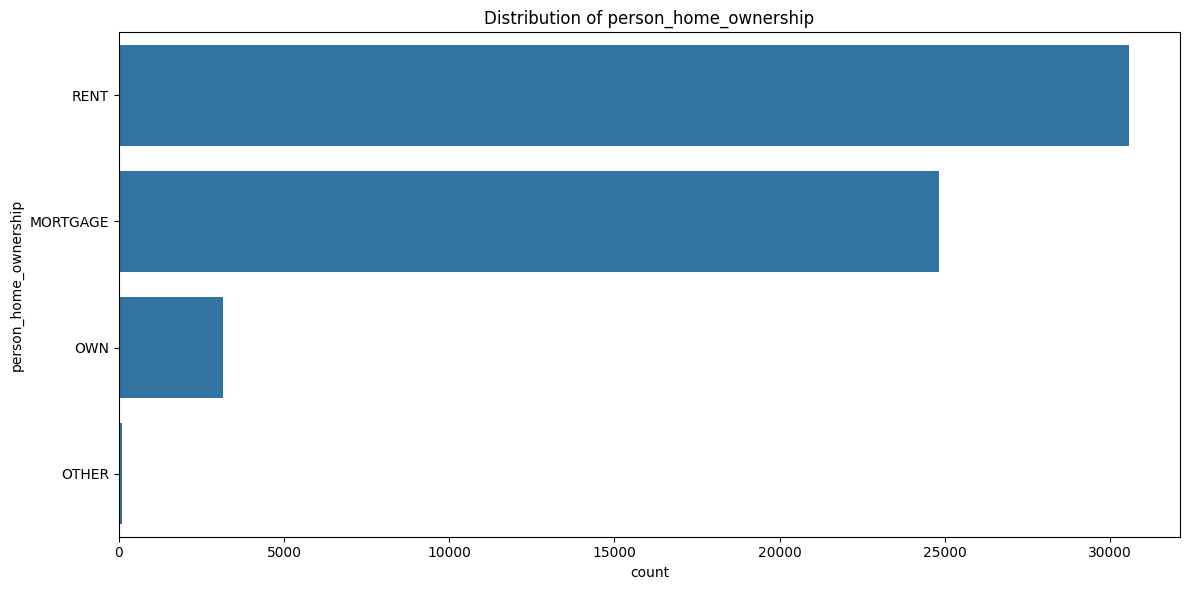

<Figure size 1200x600 with 0 Axes>

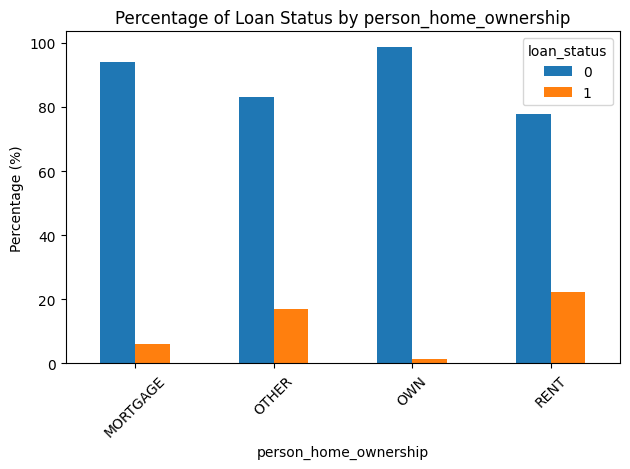


=== Analysis of loan_intent ===


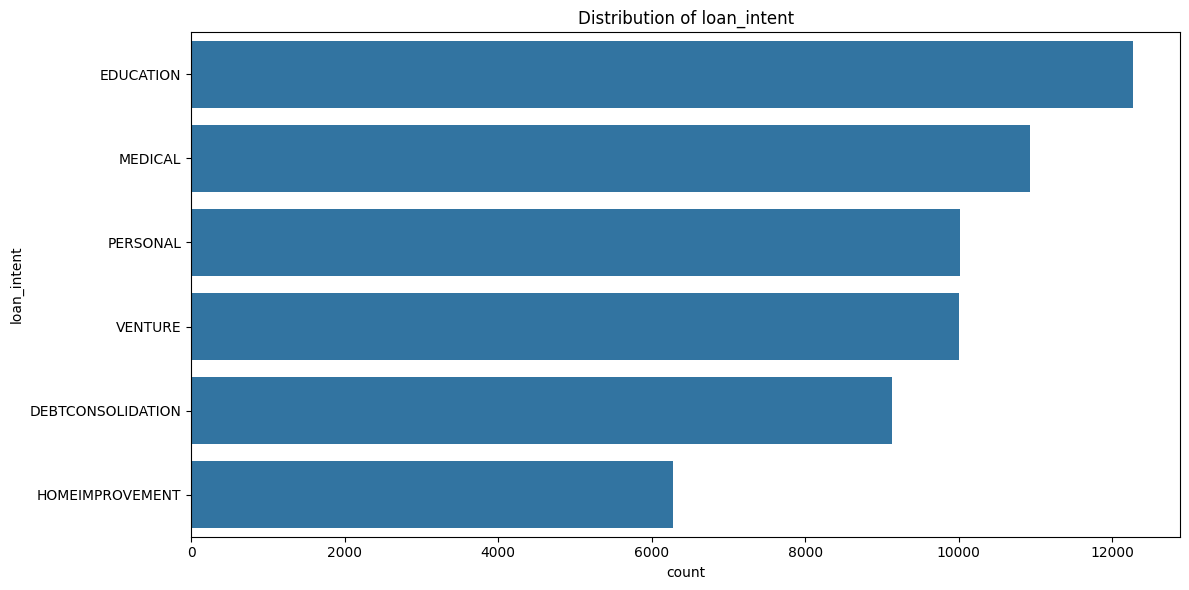

<Figure size 1200x600 with 0 Axes>

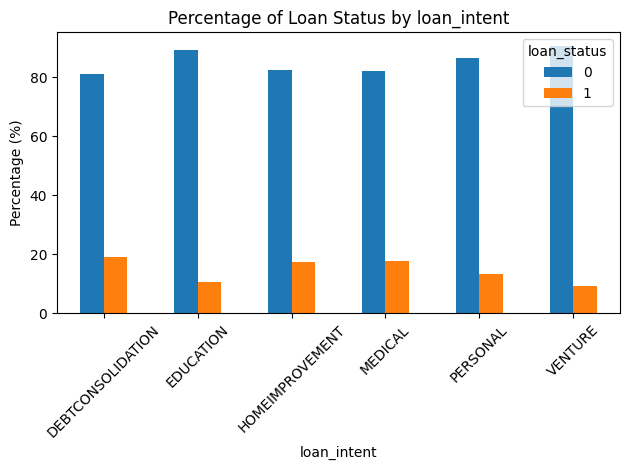


=== Analysis of loan_grade ===


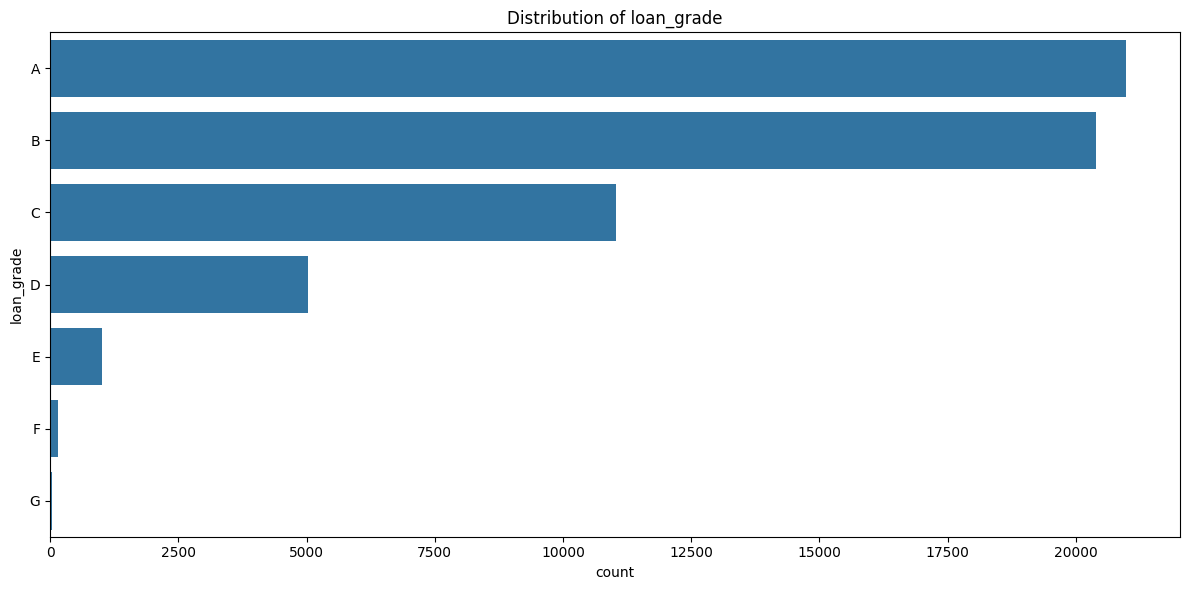

<Figure size 1200x600 with 0 Axes>

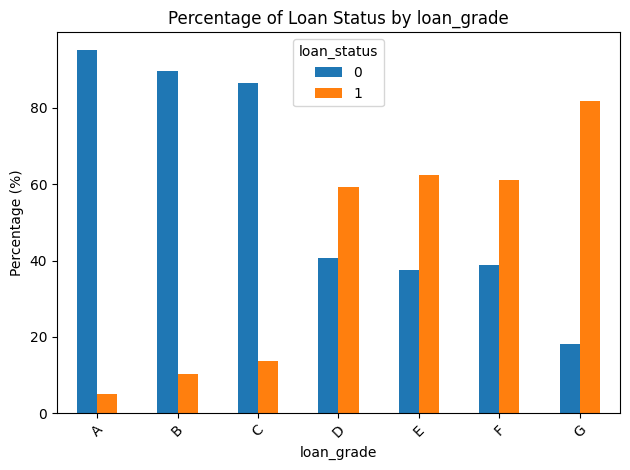


=== Analysis of cb_person_default_on_file ===


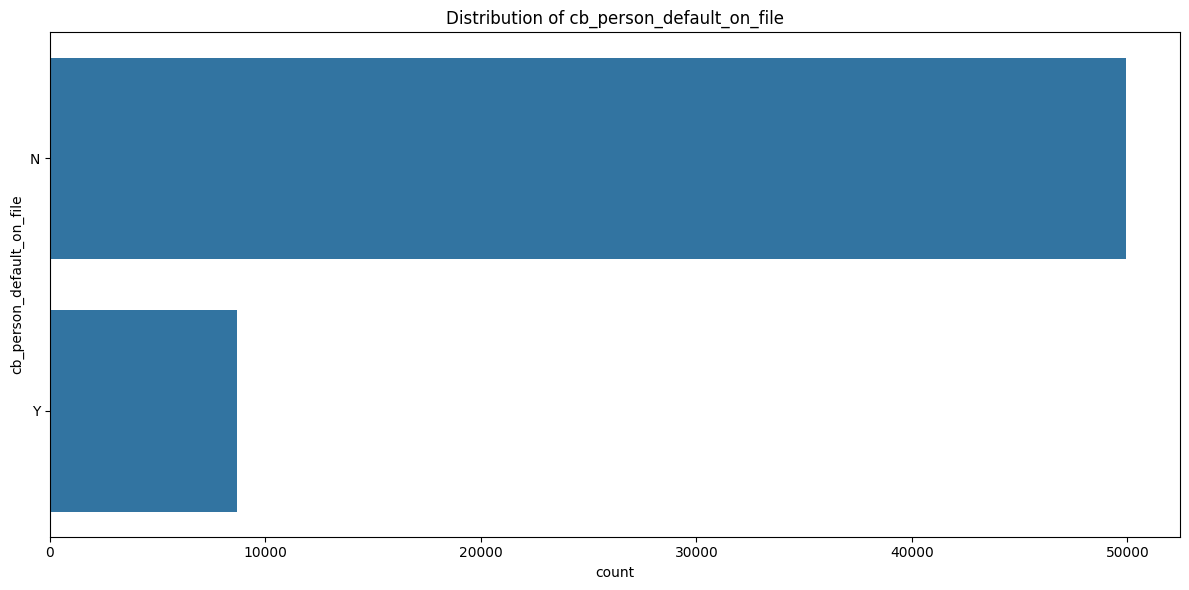

<Figure size 1200x600 with 0 Axes>

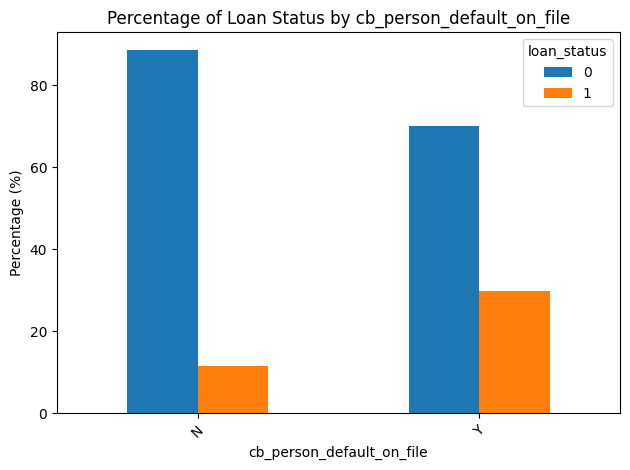

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

def analyze_numeric_attribute(df, column_name):
    print(f"\n=== Analysis of {column_name} ===")
    stats = df[column_name].describe()
    print(stats)
    
    missing = df[column_name].isna().sum()
    missing_percent = (missing / len(df)) * 100
    print(f"\nMissing values: {missing} ({missing_percent:.2f}%)")
    
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[column_name] < lower_bound) | (df[column_name] > upper_bound)).sum()
    print(f"Outliers: {outliers} ({(outliers/len(df))*100:.2f}%)")
    
    print(f"Median: {df[column_name].median()}")
    print(f"Mode: {df[column_name].mode().values[0]}")
    print(f"Variance: {df[column_name].var()}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df[column_name], kde=True, ax=ax1)
    ax1.set_title(f'Distribution of {column_name}')
    
    sns.boxplot(x=df[column_name], ax=ax2)
    ax2.set_title(f'Box Plot of {column_name}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='loan_status', y=column_name, data=df)
    plt.title(f'{column_name} by Loan Status')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_categorical_attribute(df, column_name):
    print(f"\n=== Analysis of {column_name} ===")
    
    plt.figure(figsize=(12, 6))
    sns.countplot(y=column_name, data=df, order=df[column_name].value_counts().index)
    plt.title(f'Distribution of {column_name}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    crosstab = pd.crosstab(df[column_name], df['loan_status'], normalize='index') * 100
    crosstab.plot(kind='bar', stacked=False)
    plt.title(f'Percentage of Loan Status by {column_name}')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.legend(title='loan_status')
    plt.tight_layout()
    plt.show()   

numeric_attributes = [
    'person_age', 'person_income', 'person_emp_length', 
    'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
    'cb_person_cred_hist_length'
]

categorical_attributes = [
    'person_home_ownership', 'loan_intent', 'loan_grade',
    'cb_person_default_on_file'
]

for attr in numeric_attributes:
    if attr in data.columns:
        analyze_numeric_attribute(data, attr)

for attr in categorical_attributes:
    if attr in data.columns:
        analyze_categorical_attribute(data, attr)


DECISION TREE

In [ ]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')

data = pd.get_dummies(data, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])

# Convert boolean values to integers
data = data.astype({col: int for col in data.select_dtypes(include=['bool']).columns})

# Define inputs and labels
all_inputs = data.drop(columns=["loan_status", "id"]).values  # Drop 'loan_status' and 'id' from inputs
all_labels = data["loan_status"].values  # Use 'loan_status' as label

# Check the dtype of all_inputs
print(all_inputs.dtype)


float64
[[3.700e+01 3.500e+04 0.000e+00 6.000e+03 1.149e+01 1.700e-01 1.400e+01
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [2.200e+01 5.600e+04 6.000e+00 4.000e+03 1.335e+01 7.000e-02 2.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [2.900e+01 2.880e+04 8.000e+00 6.000e+03 8.900e+00 2.100e-01 1.000e+01
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [3.000e+01 7.000e+04 1.400e+01 1.200e+04 1.111e+01 1.700e-01 5.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00

(array([ 2.,  3., 10., 20., 32., 18., 11.,  3.,  0.,  1.]),
 array([0.90731142, 0.90866867, 0.91002592, 0.91138317, 0.91274042,
        0.91409767, 0.91545492, 0.91681217, 0.91816942, 0.91952667,
        0.92088392]),
 <BarContainer object of 10 artists>)

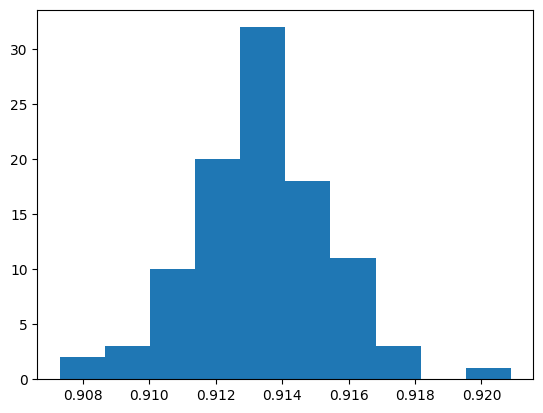

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model_accuracies = []

for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier(random_state=1)

    # Train the classifier on the training set
    decision_tree_classifier.fit(training_inputs, training_classes)

    # Validate the classifier on the testing set
    predicted_classes = decision_tree_classifier.predict(testing_inputs)

    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

plt.hist(model_accuracies)

Try decision tree with k-fold

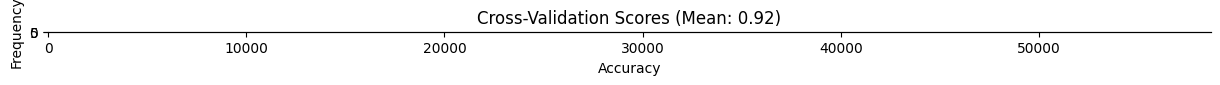

[0.91065644 0.91577153 0.91849957 0.91713555 0.91474851 0.92274898
 0.91592769 0.91780355 0.91098226 0.91354025]
Average accuracy across 10 folds: 0.92


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), all_inputs, all_labels)

from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=stratified_kfold)

plt.hist(cv_scores, bins=10, edgecolor='black')
plt.title(f'Cross-Validation Scores (Mean: {np.mean(cv_scores):.2f})')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(cv_scores)
print(f"Average accuracy across 10 folds: {np.mean(cv_scores):.2f}")

Find best performing parameters

Best score: 0.9474464735772712
Best parameters: {'max_depth': 10, 'max_features': 11}


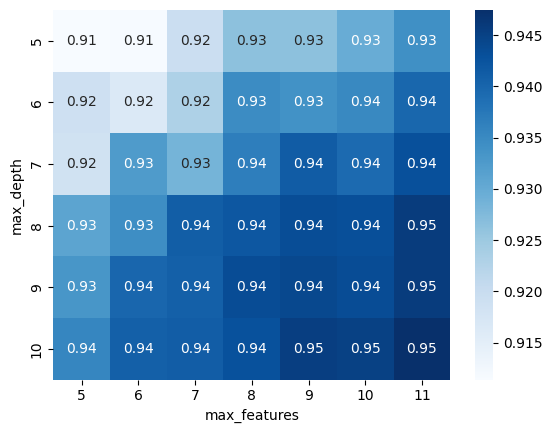

In [ ]:
from sklearn.model_selection import GridSearchCV
import seaborn as sb
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10],
    'max_features': [5, 6, 7, 8, 9, 10, 11],
}

cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(
    estimator=decision_tree_classifier,
    param_grid=parameter_grid,
    cv=cross_validation,
    scoring='accuracy'
)
grid_search.fit(all_inputs, all_labels)

grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (len(parameter_grid['max_depth']), len(parameter_grid['max_features']))

sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(len(parameter_grid['max_features'])) + 0.5, parameter_grid['max_features'])
plt.yticks(np.arange(len(parameter_grid['max_depth'])) + 0.5, parameter_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))



In [ ]:
import sklearn.tree as tree

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                    'max_depth': [5, 6, 7, 8, 9, 10],
                        'max_features': [5, 6, 7, 8, 9, 10, 11]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

decision_tree_classifier = grid_search.best_estimator_

with open('loan_tree.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

Best score: 0.9461677273673572
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 11, 'splitter': 'best'}
